In [78]:
from astropy.io import fits
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import subprocess
import pandas as pd
from sklearn.cluster import DBSCAN
from analyzeImage import analyzeImage
import keras
from keras.models import load_model
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
gpu_code_path = "../code/gpu/"
real_image_name = "chip_7"
real_image_path = "../../HITS/trimmed_chip_03/Blind15A_02/search_nights/" #gpu_code_path+"images/"+real_image_name
psi_image_path = gpu_code_path+"output-images/psi"
phi_image_path = gpu_code_path+"output-images/phi"

In [3]:
def execute(cmd):
    popen = subprocess.Popen(cmd, stdout=subprocess.PIPE, universal_newlines=True)
    for stdout_line in iter(popen.stdout.readline, ""):
        yield stdout_line 
    popen.stdout.close()
    return_code = popen.wait()
    if return_code:
        raise subprocess.CalledProcessError(return_code, cmd)

In [38]:
paramsFile = open('../code/gpu/debug/parameters.config', 'w')
paramsFile.write(
"""Debug ................ : 1
Image Count .......... : 5
Generate Images ...... : 0
Image Width .......... : 500
Image Height ......... : 500
PSF Sigma ............ : 1.0
Object Brightness .... : 360.0
Object Initial x ..... : 320.0
Object Initial y ..... : 180.0
Velocity x ........... : -1.3
Velocity y ........... : -0.2
Background Level ..... : 1024.0
Background Sigma ..... : 32.0
Mask Threshold ....... : 40.0
Mask Penalty ......... : 15.0
Angles to Search ..... : 80
Velocities to Search . : 20
Minimum Velocity ..... : 300
Maximum Velocity ..... : 450
Write to file ........ : 1
Source Images Path ... : ../../{source}/
Psi Images Path ...... : ../../{psi}/
Phi Images Path....... : ../../{phi}/
""".format( source=real_image_path, psi=psi_image_path, phi=phi_image_path ))
paramsFile.close()

In [5]:
#popen = subprocess.Popen( "./clearImages.sh", stdout=subprocess.PIPE, 
#                         stderr=subprocess.PIPE)
#popen.wait()
#output = popen.stderr.read()
#output += popen.stdout.read()
#print( output)

In [40]:
#for path in execute("./search.sh"):
#    print(path, end="")

In [53]:
raw_results = np.genfromtxt('../data/results/HITS1.txt', names=True)

In [54]:
image_mjd = []

for filename in sorted(os.listdir(real_image_path)):
    hdulist = fits.open(os.path.join(real_image_path, filename))
    image_mjd.append(hdulist[0].header['MJD'])

image_mjd = np.array(image_mjd)
image_times = image_mjd - image_mjd[0]
#image_times*=24.

Load Psi Images

In [55]:
hdulist = fits.open(os.path.join(psi_image_path, os.listdir(psi_image_path)[0]))
num_images = len(os.listdir(psi_image_path))
image_shape = np.shape(hdulist[0].data)
im_psi_array = np.zeros((num_images, image_shape[0], image_shape[1]))

for idx, filename in list(enumerate(sorted(os.listdir(psi_image_path)))):

    #print (str('Loaded ' + filename))

    image_file = os.path.join(psi_image_path, filename)
    hdulist = fits.open(image_file)
    im_psi_array[idx] = hdulist[0].data#*mask


Load Phi Images (for potentially making psi/phi stamps)

In [56]:
hdulist = fits.open(os.path.join(phi_image_path, os.listdir(phi_image_path)[0]))
num_images = len(os.listdir(phi_image_path))
image_shape = np.shape(hdulist[0].data)
im_phi_array = np.zeros((num_images, image_shape[0], image_shape[1]))

for idx, filename in list(enumerate(sorted(os.listdir(phi_image_path)))):

   # print (str('Loaded ' + filename))

    image_file = os.path.join(phi_image_path, filename)
    hdulist = fits.open(image_file)
    im_phi_array[idx] = hdulist[0].data#*mask


In [57]:
hdulist = fits.open(os.path.join(real_image_path, os.listdir(real_image_path)[0]))
num_images = len(os.listdir(real_image_path))
image_shape = np.shape(hdulist[1].data)
im_array = np.zeros((num_images, image_shape[0], image_shape[1]))


for idx, filename in list(enumerate(sorted(os.listdir(real_image_path)))):

   # print( str('Loaded ' + filename))

    image_file = os.path.join(real_image_path, filename)
    hdulist = fits.open(image_file)
    im_array[idx] = hdulist[1].data#*mask


In [58]:
ai = analyzeImage()

In [59]:
model = load_model('../data/kbmod_model.h5')

In [60]:
print(np.shape(raw_results))
results = raw_results[np.where(raw_results['likelihood'] >= 5.0)]
print(np.shape(results))
print(results)

(979582,)
(73964,)
[(102.0, 2713.0, 0.0, 0.0, -242.455, 196.366, 35.315, 7068.809)
 (102.0, 2718.0, 0.0, 0.0, -242.045, 175.883, 34.227, 6647.873)
 (102.0, 2722.0, 0.0, 0.0, -240.183, 156.003, 34.146, 6617.49) ...,
 (97.0, 3034.0, 0.0, 0.0, 183.904, -49.312, 5.0, 289.564)
 (1725.0, 2800.0, 0.0, 0.0, -564.532, 183.48, 5.0, 236.759)
 (1724.0, 2859.0, 0.0, 0.0, -504.124, -79.795, 5.0, 219.783)]


(array([  0.00000000e+00,   4.24647000e+05,   3.53117000e+05,
          8.90010000e+04,   3.88530000e+04,   2.26620000e+04,
          1.60760000e+04,   1.38070000e+04,   1.05850000e+04,
          5.68300000e+03,   2.11100000e+03,   1.49800000e+03,
          5.59000000e+02,   4.23000000e+02,   1.54000000e+02,
          1.17000000e+02,   7.60000000e+01,   5.30000000e+01,
          3.70000000e+01]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 19 Patch objects>)

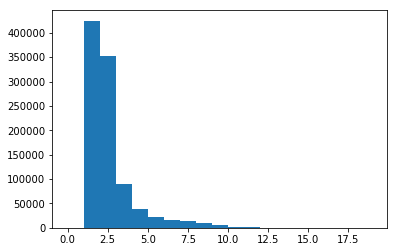

In [61]:
plt.hist(raw_results['likelihood'], bins=np.arange(20))

In [62]:
filtered_results = ai.filter_results(im_array, results, image_times, model, chunk_size=5000)

Finished chunk 1 of 15
Finished chunk 2 of 15
Finished chunk 3 of 15
Finished chunk 4 of 15
Finished chunk 5 of 15
Finished chunk 6 of 15
Finished chunk 7 of 15
Finished chunk 8 of 15
Finished chunk 9 of 15
Finished chunk 10 of 15
Finished chunk 11 of 15
Finished chunk 12 of 15
Finished chunk 13 of 15
Finished chunk 14 of 15
Finished chunk 15 of 15


In [63]:
print( len(filtered_results) )
filtered_results

30801


array([(102.0, 2713.0, 0.0, 0.0, -242.455, 196.366, 35.315, 7068.809),
       (102.0, 2718.0, 0.0, 0.0, -242.045, 175.883, 34.227, 6647.873),
       (102.0, 2722.0, 0.0, 0.0, -240.183, 156.003, 34.146, 6617.49), ...,
       (147.0, 3032.0, 0.0, 0.0, -146.825, -39.326, 5.0, 288.21),
       (37.0, 3012.0, 0.0, 0.0, 579.971, 91.856, 5.0, 245.46),
       (97.0, 3034.0, 0.0, 0.0, 183.904, -49.312, 5.0, 289.564)], 
      dtype=[('t0_x', '<f8'), ('t0_y', '<f8'), ('theta_par', '<f8'), ('theta_perp', '<f8'), ('v_x', '<f8'), ('v_y', '<f8'), ('likelihood', '<f8'), ('est_flux', '<f8')])

In [64]:
results_to_cluster = filtered_results
arg = dict(eps=0.03, min_samples=1, n_jobs=-1)
clustered_results = ai.clusterResults(results_to_cluster, dbscan_args=arg)#, im_array, image_times)
clustered_results =  results_to_cluster[np.array(clustered_results[1], dtype=np.int)]
#best_targets = range(stamp_count)
#best_targets

In [65]:
print( len(clustered_results) )
clustered_results

5


array([(102.0, 2713.0, 0.0, 0.0, -242.455, 196.366, 35.315, 7068.809),
       (1642.0, 2846.0, 0.0, 0.0, -13.074, -20.126, 9.939, 482.025),
       (128.0, 3099.0, 0.0, 0.0, -25.103, -477.741, 6.704, 496.191),
       (1528.0, 3494.0, 0.0, 0.0, -391.717, -317.133, 5.69, 352.084),
       (1511.0, 3459.0, 0.0, 0.0, -142.028, 218.734, 5.572, 347.106)], 
      dtype=[('t0_x', '<f8'), ('t0_y', '<f8'), ('theta_par', '<f8'), ('theta_perp', '<f8'), ('v_x', '<f8'), ('v_y', '<f8'), ('likelihood', '<f8'), ('est_flux', '<f8')])

In [118]:
test = [[1,2], [3,4], [5,6]]
blank = []

In [121]:
for x in test:
    blank.append(x)

In [122]:
blank

[[1, 2], [3, 4], [5, 6], [1, 2], [3, 4], [5, 6]]

In [89]:
df = pd.DataFrame(columns=['t0_x', 't0_y', 'theta_par', 'theta_perp', 'v_x', 'v_y', 'likelihood', 'est_flux', 'chip_num'])

In [91]:
new_df = pd.DataFrame.from_records(clustered_results)

In [92]:
new_df['chip_num'] = 3

In [93]:
df.append(new_df, ignore_index=True)

,t0_x,t0_y,theta_par,theta_perp,v_x,v_y,likelihood,est_flux,chip_num
0,102.0,2713.0,0.0,0.0,-242.455,196.366,35.315,7068.809,3.0
1,1642.0,2846.0,0.0,0.0,-13.074,-20.126,9.939,482.025,3.0
2,128.0,3099.0,0.0,0.0,-25.103,-477.741,6.704,496.191,3.0
3,1528.0,3494.0,0.0,0.0,-391.717,-317.133,5.690,352.084,3.0
4,1511.0,3459.0,0.0,0.0,-142.028,218.734,5.572,347.106,3.0


In [98]:
df = df.append(new_df, ignore_index=True)

In [99]:
df

,t0_x,t0_y,theta_par,theta_perp,v_x,v_y,likelihood,est_flux,chip_num
0,102.0,2713.0,0.0,0.0,-242.455,196.366,35.315,7068.809,3.0
1,1642.0,2846.0,0.0,0.0,-13.074,-20.126,9.939,482.025,3.0
2,128.0,3099.0,0.0,0.0,-25.103,-477.741,6.704,496.191,3.0
3,1528.0,3494.0,0.0,0.0,-391.717,-317.133,5.690,352.084,3.0
4,1511.0,3459.0,0.0,0.0,-142.028,218.734,5.572,347.106,3.0
5,102.0,2713.0,0.0,0.0,-242.455,196.366,35.315,7068.809,3.0
6,1642.0,2846.0,0.0,0.0,-13.074,-20.126,9.939,482.025,3.0
7,128.0,3099.0,0.0,0.0,-25.103,-477.741,6.704,496.191,3.0
8,1528.0,3494.0,0.0,0.0,-391.717,-317.133,5.690,352.084,3.0
9,1511.0,3459.0,0.0,0.0,-142.028,218.734,5.572,347.106,3.0


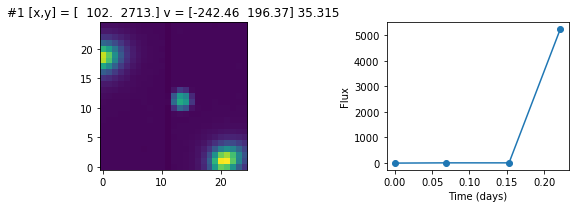

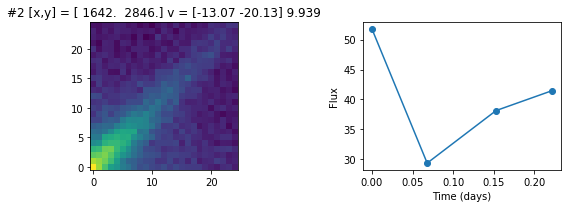

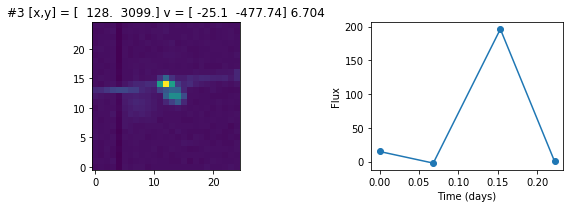

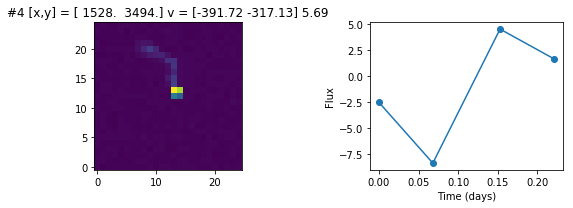

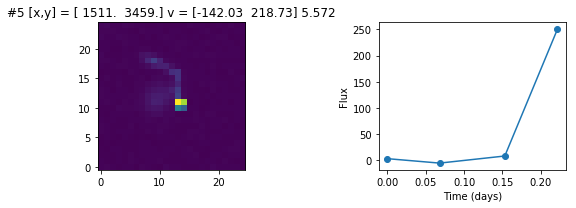

In [73]:
f_results = clustered_results#filtered_results
rejected = 0
for imNum in range(min(len(f_results),40)):
    current = imNum#best_targets[imNum]
    fig = plt.figure(figsize=(8,3))
    fig.add_subplot(121)
    plt.imshow(ai.createPostageStamp(im_array,
                                         list(f_results[['t0_x', 't0_y']][current]),
                                         np.array(list(f_results[['v_x', 'v_y']][current])),
                                         image_times, 
                                         [25., 25.])[0],
                    origin='lower',
               #cmap=plt.cm.Greys_r,
               interpolation='None')
    plt.title(str('#' + str(imNum+1) + ' [x,y] = ' + str(np.round(list(f_results[['t0_x', 't0_y']][current]), 2))
                  + ' v = ' + str(np.round(list(f_results[['v_x', 'v_y']][current]),2)) + ' ' +
                  str(f_results['likelihood'][current])))
    fig.add_subplot(122)
    ai.plotLightCurves(im_array, f_results[current], image_times)
    plt.tight_layout()
    traj_coords = ai.calc_traj_coords(f_results[current], image_times)
    light_curve = [im_array[x, traj_coords[x,1], traj_coords[x,0]] for x in range(len(im_array))]
    if np.max(light_curve) > 20*np.median(light_curve):
        rejected+=1
    elif np.median(light_curve) < 0.:
        rejected+=1
 #   plt.savefig("stamps/stamp"+str(imNum+1)+".png")
    plt.show()


In [74]:
image_times

array([ 0.       ,  0.0680697,  0.153044 ,  0.2217088])

In [75]:
rejected

4

In [77]:
f_results[[2,4]]

array([(128.0, 3099.0, 0.0, 0.0, -25.103, -477.741, 6.704, 496.191),
       (1511.0, 3459.0, 0.0, 0.0, -142.028, 218.734, 5.572, 347.106)], 
      dtype=[('t0_x', '<f8'), ('t0_y', '<f8'), ('theta_par', '<f8'), ('theta_perp', '<f8'), ('v_x', '<f8'), ('v_y', '<f8'), ('likelihood', '<f8'), ('est_flux', '<f8')])